##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 2


**Student ID:**     `1418850`


This iPython notebook is a template which you will use for your Assignment 1 submission.

**NOTE: YOU SHOULD ADD YOUR RESULTS, GRAPHS, AND FIGURES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).** Results, figures, etc. which appear in this file but are NOT included in your report will not be marked.

**Adding proper comments to your code is MANDATORY. **

# Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from functools import reduce
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from skimage.feature import local_binary_pattern
from scipy.stats import randint, uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.regularizers import l2

## Load & merge training data


In [51]:
# Load the metadata (contains Id, filename, ClassId)
train_meta = pd.read_csv('train/train_metadata.csv')

# Load each feature set
train_colour = pd.read_csv('train/Features/color_histogram.csv')
train_hog = pd.read_csv('train/Features/hog_pca.csv')
train_add = pd.read_csv('train/Features/additional_features.csv')

# Merge them all on the common 'image_path' column
dataframes = [train_meta, train_colour, train_hog, train_add]
train_df = reduce(lambda left, right: pd.merge(left, right, on='image_path'), dataframes)

train_df['filepath'] = train_df['image_path'].apply(
    lambda f: os.path.join('train', f)
)

print(f"Merged training set shape: {train_df.shape}")
print(train_df.head())

Merged training set shape: (5488, 124)
     id      image_path  ClassId      ch_0      ch_1      ch_2      ch_3  \
0  7218  img_000001.jpg       32  0.000000  0.000000  0.268901  0.355617   
1  6333  img_000002.jpg       13  0.000000  0.002267  0.657901  0.641467   
2  6867  img_000003.jpg        7  0.002243  0.143541  0.385766  0.091956   
3  7730  img_000004.jpg        4  0.000000  0.096069  0.947646  0.217350   
4  6338  img_000005.jpg       35  0.000000  0.000000  0.000000  0.000000   

       ch_4      ch_5      ch_6  ...  hog_pca_15  hog_pca_16  hog_pca_17  \
0  0.511548  0.264923  0.526664  ...    0.450825   -0.213796   -0.882416   
1  0.222700  0.243100  0.108233  ...   -0.335682   -0.886182    0.507969   
2  0.066163  0.204097  0.353245  ...    0.501386   -0.421448    0.081289   
3  0.160404  0.083028  0.042601  ...    0.285638   -0.481589   -0.101580   
4  0.000000  0.015324  0.029918  ...   -0.520063    0.062209    0.248771   

   hog_pca_18  hog_pca_19  edge_density      me

## Load & merge test data

In [38]:
# Load test metadata  
test_meta  = pd.read_csv('test/test_metadata.csv')

# Load each test feature file  
test_color = pd.read_csv('test/Features/color_histogram.csv')
test_hog   = pd.read_csv('test/Features/hog_pca.csv')
test_add   = pd.read_csv('test/Features/additional_features.csv')

# Merge on 'image_path'  
test_dfs = [test_meta, test_color, test_hog, test_add]
test_df  = reduce(lambda left, right: pd.merge(left, right, on='image_path'), test_dfs)

test_df['filepath'] = test_df['image_path'].apply(lambda x: os.path.join("test", x))
  
print(f"Merged test set shape: {test_df.shape}")   # should be (2353, 123)
print(test_df.head())


Merged test set shape: (2353, 124)
     id      image_path  ClassId  ch_0      ch_1      ch_2      ch_3  \
0   661  img_005489.jpg      NaN   0.0  0.043099  0.018964  0.031606   
1  4477  img_005490.jpg      NaN   0.0  0.046065  0.411173  0.651735   
2  1046  img_005491.jpg      NaN   0.0  0.006825  0.040948  0.170616   
3   631  img_005492.jpg      NaN   0.0  0.000000  0.000000  0.021120   
4  6533  img_005493.jpg      NaN   0.0  0.000000  0.299374  0.917305   

       ch_4      ch_5      ch_6  ...  hog_pca_15  hog_pca_16  hog_pca_17  \
0  0.056316  0.049421  0.019538  ...   -0.301160   -0.334299    0.138616   
1  0.175730  0.132224  0.185966  ...    0.829642    0.137557    0.487105   
2  0.316492  0.324170  0.271279  ...    0.182572   -0.373714    0.262148   
3  0.815159  0.551828  0.135710  ...    0.411835   -0.654511    0.084131   
4  0.168114  0.111571  0.102989  ...   -0.020706    0.609833    0.413756   

   hog_pca_18  hog_pca_19  edge_density      mean_b      mean_g      mean_r

## Exploratory data analysis

Top 10 columns by missing values:
id       0
ch_75    0
ch_88    0
ch_87    0
ch_86    0
ch_85    0
ch_84    0
ch_83    0
ch_82    0
ch_81    0
dtype: int64


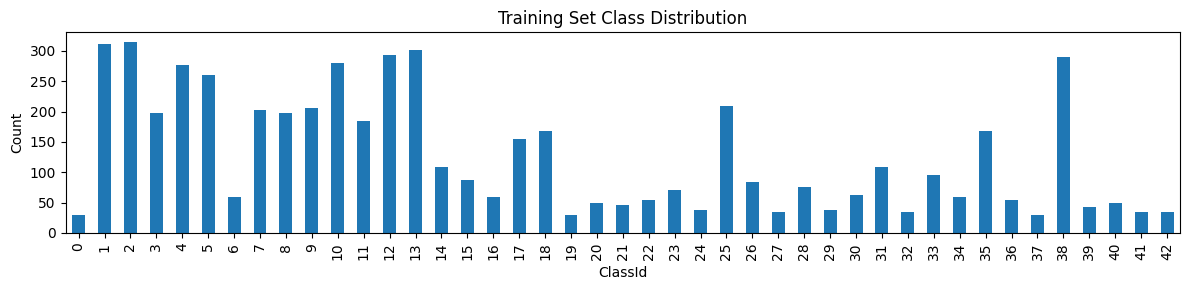

First 10 features summary:
          count         mean          std  min          25%          50%  \
id       5488.0  3909.515124  2263.069618  1.0  1954.750000  3917.500000   
ClassId  5488.0    15.795190    12.018043  0.0     5.000000    12.000000   
ch_0     5488.0     0.001594     0.017190  0.0     0.000000     0.000000   
ch_1     5488.0     0.091166     0.222423  0.0     0.000000     0.000681   
ch_2     5488.0     0.233191     0.300232  0.0     0.000701     0.060961   
ch_3     5488.0     0.261800     0.257555  0.0     0.030304     0.190260   
ch_4     5488.0     0.248081     0.222946  0.0     0.074960     0.186151   
ch_5     5488.0     0.219207     0.193436  0.0     0.072523     0.166587   
ch_6     5488.0     0.185793     0.169253  0.0     0.060665     0.138320   
ch_7     5488.0     0.155622     0.146814  0.0     0.049787     0.114759   

                 75%          max  
id       5867.500000  7840.000000  
ClassId    25.000000    42.000000  
ch_0        0.000000     0.6

In [39]:
# 1. Missing‐value check
missing = train_df.isna().sum().sort_values(ascending=False)
print("Top 10 columns by missing values:")
print(missing.head(10))

# 2. Class‐balance bar chart
plt.figure(figsize=(12, 3))
train_df['ClassId']\
    .value_counts()\
    .sort_index()\
    .plot(kind='bar')
plt.xlabel('ClassId')
plt.ylabel('Count')
plt.title('Training Set Class Distribution')
plt.tight_layout()
plt.show()

# 3. Numeric feature summary
summary = train_df.describe().T
print("First 10 features summary:")
print(summary.head(10))


## Baseline pipelines + 5-fold CV

In [40]:
# 1. Prepare X, y
X = train_df.drop(['id', 'image_path', 'ClassId', 'filepath'], axis=1)
y = train_df['ClassId']

# 2. Define 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro']

# 3. Pipelines
pipelines = {
    'kNN': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ]),
    'RandomForest': Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, 
                                      class_weight='balanced',
                                      random_state=42, n_jobs=-1))
    ])
}

# 4. Cross‐validate each
results = {}
for name, pipe in pipelines.items():
    cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    results[name] = {
        metric: (np.mean(cv_res[f'test_{metric}']), 
                 np.std(cv_res[f'test_{metric}']))
        for metric in scoring
    }

# 5. Print a summary
for name, metrics in results.items():
    print(f"\n=== {name} ===")
    for metric, (mean, std) in metrics.items():
        print(f"{metric:15s}: {mean:.3f} ± {std:.3f}")



=== kNN ===
accuracy       : 0.616 ± 0.011
precision_macro: 0.669 ± 0.027
recall_macro   : 0.563 ± 0.018

=== RandomForest ===
accuracy       : 0.792 ± 0.008
precision_macro: 0.863 ± 0.011
recall_macro   : 0.735 ± 0.010


# hyperparameter tuning

In [ ]:
# 1. Rebuild your RF pipeline
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 2. Define search space (distributions for RandomizedSearch)
param_dist = {
    'rf__n_estimators':       randint(100, 501),       # 100–500 trees
    'rf__max_depth':          [None, 10, 20, 30, 40],   # None or shallow depths
    'rf__max_features':       ['sqrt', 'log2', None],   
    'rf__min_samples_split':  randint(2, 11),           # 2–10 samples to split
    'rf__min_samples_leaf':   randint(1, 5)             # 1–4 samples per leaf
}

# 3. Stratified CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. RandomizedSearchCV
rs = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=50,                   # try 50 random combinations
    scoring='accuracy',          # or 'precision_macro' / 'recall_macro'
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 5. Fit on the full training set
rs.fit(X, y)

# 6. Results
print("Best accuracy: ", rs.best_score_)
print("Best parameters:", rs.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best accuracy:  0.8119554406536789
Best parameters: {'rf__max_depth': 30, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 4, 'rf__n_estimators': 463}


# re-evaluate tuned model performance

In [41]:
# 1. Rebuild the tuned pipeline with the best params
best_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=463,
        max_depth=30,
        max_features='sqrt',
        min_samples_split=4,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

# 2. Fit on all of the training data
best_rf.fit(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro']

cv_res = cross_validate(best_rf, X, y, cv=cv, scoring=scoring, n_jobs=-1)
for metric in scoring:
    mean = cv_res[f'test_{metric}'].mean()
    std = cv_res[f'test_{metric}'].std()
    print(f"{metric:15s}: {mean:.3f} ± {std:.3f}")

accuracy       : 0.812 ± 0.008
precision_macro: 0.880 ± 0.003
recall_macro   : 0.769 ± 0.013


# generate test-set predictions

In [42]:
# X_test features only
X_test = test_df.drop(['id','image_path', 'ClassId'], axis=1)

# Reorder to match training set columns
X_test = X_test[X.columns]

# Predict
test_preds = best_rf.predict(X_test)

# Build submission DataFrame
submission = pd.DataFrame({
    'id':      test_df['id'],
    'ClassId': test_preds
})

submission.to_csv('submission.csv', index=False)
print("Wrote submission.csv with", len(submission), "rows.")
# Submission file should have 2353 rows, matching the test set size

Wrote submission.csv with 2353 rows.


# confusion matrix

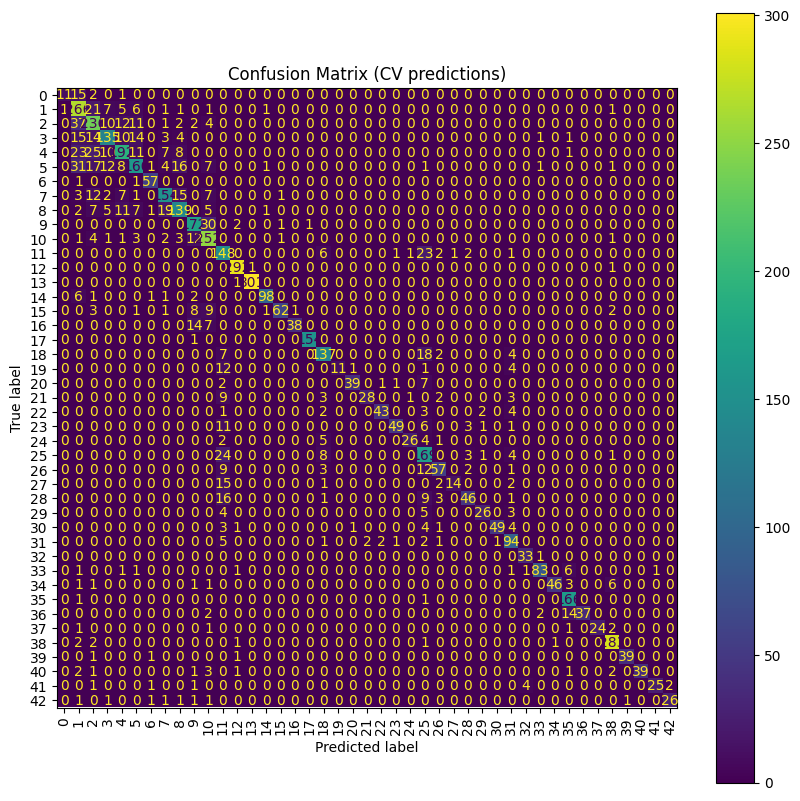

In [43]:
# Run CV predictions
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(best_rf, X, y, cv=cv, n_jobs=-1)

cm = confusion_matrix(y, y_pred, labels=best_rf.named_steps['rf'].classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=best_rf.named_steps['rf'].classes_)
plt.figure(figsize=(10,10))
disp.plot(ax=plt.gca(), xticks_rotation='vertical')
plt.title('Confusion Matrix (CV predictions)')
plt.show()


# cnn

In [ ]:
# parameters
TARGET_SIZE = (64, 64)  # Resize images to 64x64
BATCH_SIZE = 32
NUM_CLASSES = 43
EPOCHS = 30


train_df['ClassId'] = train_df['ClassId'].astype(str)  # Convert to string for categorical labels


# Data generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
)

train_loader = train_gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='ClassId',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

idx_to_label = {v: int(k) for k, v in train_loader.class_indices.items()}

val_loader = train_gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='ClassId',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

# build simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*TARGET_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_cnn.h5', save_best_only=True)
]

# train the model
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=EPOCHS,
    callbacks=callbacks
)

# prepare test loader & predict
test_gen = ImageDataGenerator(rescale=1./255)
test_loader = test_gen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col=None,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

preds = model.predict(test_loader, verbose = 1)
pred_idx = np.argmax(preds, axis=1)
pred_labels = [idx_to_label[id] for id in pred_idx]

# write submission
submission_cnn = pd.DataFrame({
    'id':      test_df['id'],
    'ClassId': pred_labels
})
submission_cnn.to_csv('submission_cnn.csv', index=False)
print("Wrote submission_cnn.csv with", len(submission_cnn), "rows.")

Found 4391 validated image filenames belonging to 43 classes.
Found 1097 validated image filenames belonging to 43 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856    

c:\Users\zmoba\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/138 [==============================] - 20s 143ms/step - loss: 2.7687 - accuracy: 0.2517 - val_loss: 2.2868 - val_accuracy: 0.3582
Epoch 3/30
138/138 [==============================] - 19s 136ms/step - loss: 2.3033 - accuracy: 0.3361 - val_loss: 1.9208 - val_accuracy: 0.4512
Epoch 4/30
138/138 [==============================] - 20s 146ms/step - loss: 1.9986 - accuracy: 0.3981 - val_loss: 1.5758 - val_accuracy: 0.5160
Epoch 5/30
138/138 [==============================] - 19s 139ms/step - loss: 1.7802 - accuracy: 0.4473 - val_loss: 1.4399 - val_accuracy: 0.5479
Epoch 6/30
138/138 [==============================] - 19s 141ms/step - loss: 1.6091 - accuracy: 0.4899 - val_loss: 1.2712 - val_accuracy: 0.5953
Epoch 7/30
138/138 [==============================] - 19s 138ms/step - loss: 1.4501 - accuracy: 0.5263 - val_loss: 1.2006 - val_accuracy: 0.6472
Epoch 8/30
138/138 [==============================] - 19s 140ms/step - loss: 1.3363 - accuracy: 0.5662 - val_loss: 0.9995 - val_accuracy: 0.6

Train accuracy:  0.8697335720062256 
Validation accuracy:  0.9179580807685852
35/35 [==============================] - 3s 90ms/step
Validation accuracy: 0.9179580674567


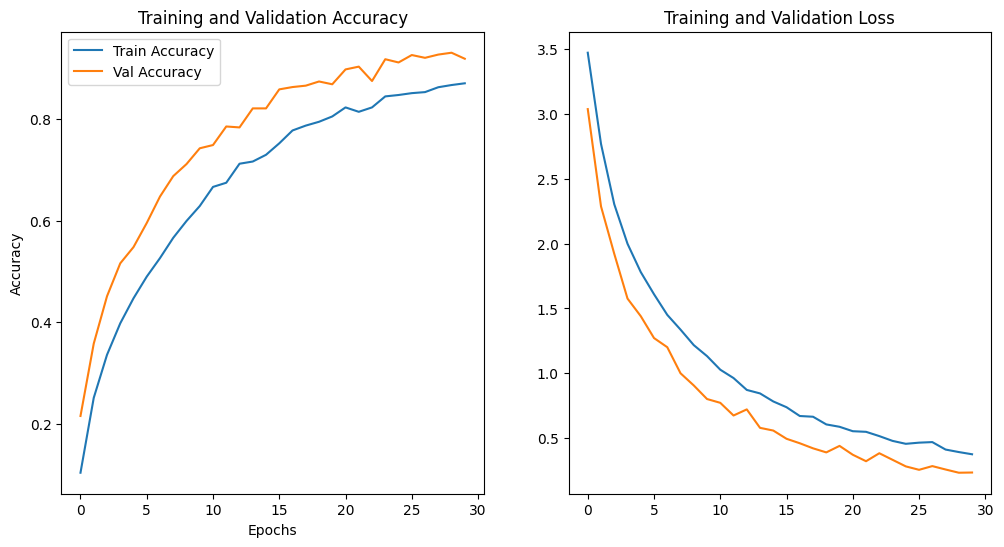

In [22]:
print("Train accuracy: ", history.history['accuracy'][-1], "\nValidation accuracy: ", history.history['val_accuracy'][-1])
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')


val_preds = model.predict(val_loader, verbose=1)
val_pred_idx = np.argmax(val_preds, axis=1)
true_idx     = val_loader.classes   # the integer labels

from sklearn.metrics import accuracy_score
print("Validation accuracy:", accuracy_score(true_idx, val_pred_idx))

# cnn model trained on images

In [55]:
# --- 1. Set parameters ---
IMG_SIZE = (32,32)
NUM_CLASSES = 43
BATCH_SIZE = 64
EPOCHS = 30
ALPHA = 0.6               # weight for ensemble

# --- 2. Load and merge training metadata + features ---
train_meta  = pd.read_csv('train/train_metadata.csv')
train_color = pd.read_csv('train/Features/color_histogram.csv')
train_hog   = pd.read_csv('train/Features/hog_pca.csv')
train_add   = pd.read_csv('train/Features/additional_features.csv')

train_df_cnn = (
    train_meta
    .merge(train_color, on='image_path')
    .merge(train_hog,   on='image_path')
    .merge(train_add,   on='image_path')
)

train_df_cnn['filepath'] = train_df_cnn['image_path'].apply(lambda f: os.path.join('train', f))

# --- 3. Prepare numpy arrays for images, features, and labels ---
# Load all images into memory
X_img = np.stack([
    img_to_array(load_img(fp, target_size=IMG_SIZE)) / 255.0
    for fp in train_df_cnn['filepath']
])

# Handcrafted feature matrix
feature_cols = [c for c in train_color.columns if c.startswith('ch_')] + \
               [c for c in train_hog.columns   if c.startswith('hog_pca_')] + \
               ['edge_density', 'mean_b', 'mean_g', 'mean_r']
X_feat = train_df_cnn[feature_cols].values.astype('float32')

# Labels
y = train_df_cnn['ClassId'].values.astype('int32')

# Train/validation split
X_img_train, X_img_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
    X_img, X_feat, y, stratify=y, test_size=0.2, random_state=42
)

# --- 4. Define and train a small CNN on images only ---
cnn = Sequential([
    InputLayer(input_shape=(*IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu', input_shape=(*TARGET_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
cnn.fit(
    X_img_train, y_train,
    validation_data=(X_img_val, y_val),
    batch_size=BATCH_SIZE, epochs=EPOCHS
)
cnn_val_acc = cnn.evaluate(X_img_val, y_val, verbose=0)[1]
print(f"Small CNN validation accuracy: {cnn_val_acc:.4f}")

Epoch 1/30
69/69 [==============================] - 7s 70ms/step - loss: 3.5608 - accuracy: 0.0745 - val_loss: 3.2958 - val_accuracy: 0.1330
Epoch 2/30
69/69 [==============================] - 4s 65ms/step - loss: 3.0778 - accuracy: 0.1779 - val_loss: 2.5979 - val_accuracy: 0.3206
Epoch 3/30
69/69 [==============================] - 5s 67ms/step - loss: 2.4360 - accuracy: 0.3298 - val_loss: 1.9136 - val_accuracy: 0.4554
Epoch 4/30
69/69 [==============================] - 5s 66ms/step - loss: 1.8781 - accuracy: 0.4483 - val_loss: 1.4399 - val_accuracy: 0.5729
Epoch 5/30
69/69 [==============================] - 4s 65ms/step - loss: 1.5150 - accuracy: 0.5460 - val_loss: 1.1629 - val_accuracy: 0.6803
Epoch 6/30
69/69 [==============================] - 4s 58ms/step - loss: 1.2224 - accuracy: 0.6182 - val_loss: 0.8714 - val_accuracy: 0.7423
Epoch 7/30
69/69 [==============================] - 5s 66ms/step - loss: 0.9867 - accuracy: 0.6952 - val_loss: 0.7391 - val_accuracy: 0.7996
Epoch 8/30
69

# mlp trained on features

In [56]:
# 1) Learning-rate schedules
cosine_schedule = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    alpha=1e-2              # final LR = 0.01 * initial
)
exp_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=400,
    decay_rate=0.4,
    staircase=True
)

# pick one:
# optimizer = tf.keras.optimizers.Adam(learning_rate=cosine_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=exp_schedule)

# 2) Build the “tuned” MLP
mlp = Sequential([
    InputLayer(input_shape=(X_feat_train.shape[1],)),

    # Layer block 1
    Dense(1024, activation=None,
          kernel_regularizer=l2(1e-4)),   # L2 on weights
    BatchNormalization(),
    LeakyReLU(alpha=0.1),               # smooth LeakyReLU
    Dropout(0.5),

    # Layer block 2
    Dense(512, activation=None,
          kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('elu'),                  # SELU activation
    Dropout(0.5),

    # Layer block 3
    Dense(256, activation=None,
          kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),                 # plain ReLU
    Dropout(0.3),

    # Final classification head
    Dense(NUM_CLASSES, activation='softmax')
])

mlp.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3) Callbacks for stable training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
]

# 4) Train
history = mlp.fit(
    X_feat_train, y_train,
    validation_data=(X_feat_val, y_val),
    batch_size=64,
    epochs=50,
    callbacks=callbacks
)

# 5) Evaluate
val_loss, val_acc = mlp.evaluate(X_feat_val, y_val, verbose=0)
print(f"Tuned MLP validation accuracy: {val_acc:.4f}")


Epoch 1/50
69/69 [==============================] - 12s 42ms/step - loss: 3.7278 - accuracy: 0.1166 - val_loss: 5.0610 - val_accuracy: 0.0974 - lr: 0.0100
Epoch 2/50
69/69 [==============================] - 2s 34ms/step - loss: 2.6999 - accuracy: 0.3308 - val_loss: 4.1503 - val_accuracy: 0.1485 - lr: 0.0100
Epoch 3/50
69/69 [==============================] - 2s 34ms/step - loss: 2.4637 - accuracy: 0.3925 - val_loss: 2.9326 - val_accuracy: 0.3233 - lr: 0.0100
Epoch 4/50
69/69 [==============================] - 2s 35ms/step - loss: 2.3610 - accuracy: 0.4355 - val_loss: 3.4788 - val_accuracy: 0.2550 - lr: 0.0100
Epoch 5/50
69/69 [==============================] - 2s 34ms/step - loss: 2.3173 - accuracy: 0.4401 - val_loss: 2.5720 - val_accuracy: 0.4153 - lr: 0.0100
Epoch 6/50
69/69 [==============================] - 2s 34ms/step - loss: 2.2252 - accuracy: 0.4777 - val_loss: 2.3462 - val_accuracy: 0.4290 - lr: 0.0040
Epoch 7/50
69/69 [==============================] - 2s 34ms/step - loss: 1.

# lbp model

In [ ]:
# Parameters for LBP
RADIUS = 1
POINTS = 8 * RADIUS
METHOD = 'ror'

def lbp_multi_scale(img_gray: np.ndarray,
    radii        = [1,2,3],
    points_per_radius = 8,
    method       = 'uniform'
) -> np.ndarray:
    """
    img_gray: HxW uint8 gray image
    radii: list of radii to compute
    points_per_radius: base number of sample points (so P = points_per_radius * R)
    method: one of 'uniform', 'ror', 'var', etc.
    Returns a 1D float32 vector of concatenated LBP histograms.
    """
    feats = []
    for R in radii:
        P = points_per_radius * R
        # compute LBP with small, fixed number of patterns
        lbp = local_binary_pattern(img_gray, P=P, R=R, method=method)
        
        # for 'uniform', there are P+2 possible codes
        # for 'ror', also P+2; for 'var', it's P
        # here we handle uniform/ror explicitly, else fallback to P+2
        if method in ('uniform','ror'):
            n_bins = P + 2
        elif method == 'var':
            n_bins = P
        else:
            # if you ever use 'default', this will still blow up,
            # so best avoid 'default' entirely.
            n_bins = P + 2
        
        # build a fast bincount + normalize
        counts = np.bincount(
            lbp.ravel().astype(int),
            minlength=n_bins
        ).astype('float32')
        hist   = counts / counts.sum()   # density=True equivalent
        feats.append(hist)
    
    return np.concatenate(feats, axis=0)

# Usage on training set:
X_gray_train = [cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY) 
          for img in X_img_train]  # X_img_train in [0,1]

X_lbp_ms_train = np.vstack([
    lbp_multi_scale(g, radii=[1,2,3], points_per_radius=8, method='uniform')
    for g in X_gray_train
])

X_gray_val = [cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY) 
            for img in X_img_val]

X_lbp_ms_val = np.vstack([
    lbp_multi_scale(g, radii=[1,2,3], points_per_radius=8, method='uniform')
    for g in X_gray_val
])




def lbp_color(img_rgb, radii=[1,2], points_per_radius=8, method='uniform'):
    """
    img_rgb: HxWx3 float32 in [0,1]
    returns: concatenated LBP histograms of each channel
    """
    # convert to uint8 for skimage
    img_uint8 = (img_rgb * 255).astype('uint8')
    feats = []
    # on RGB channels
    for c in range(3):
        gray = img_uint8[..., c]
        feats.append(lbp_multi_scale(gray, radii, points_per_radius, method))
    return np.concatenate(feats)

X_lbp_color_train = np.vstack([lbp_color(img) for img in X_img_train])
X_lbp_color_val   = np.vstack([lbp_color(img) for img in X_img_val])



X_combined_train = np.hstack([
    X_lbp_ms_train,     # multi‐scale grayscale LBP
    X_lbp_color_train   # color‐LBP
])

X_combined_val = np.hstack([
    X_lbp_ms_val,
    X_lbp_color_val
])

# Hyperparameter tuning
param_dist = {
    'max_iter':       randint(200, 1001),
    'max_depth':      [None, 5, 10, 15],
    'learning_rate':  uniform(0.01, 0.19),
    'max_leaf_nodes': [31, 63, 127, 255]
}

hgb = HistGradientBoostingClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    hgb, param_dist, n_iter=30, scoring='accuracy',
    cv=cv, n_jobs=-1, random_state=42, verbose=1
)

rs.fit(X_combined_train, y_train)
print("Best params:", rs.best_params_)
print("Best CV acc:", rs.best_score_)

# Evaluate on hold‐out
best_hgb = rs.best_estimator_
val_acc_hgb = best_hgb.score(X_combined_val, y_val)
print("Tuned LBP-HGB val accuracy:", val_acc_hgb)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'learning_rate': 0.024164622299156457, 'max_depth': 10, 'max_iter': 720, 'max_leaf_nodes': 255}
Best CV acc: 0.4230068337129841
Tuned LBP-HGB val accuracy: 0.44808743169398907


'\nthird_model = HistGradientBoostingClassifier(\n    max_iter=200,\n    random_state=42\n)\nthird_model.fit(X_lbp_ms_train, y_train)\n\n# check its hold-out accuracy\nval_acc_3 = third_model.score(X_lbp_ms_val, y_val)\nprint(f"LBP-model validation accuracy: {val_acc_3:.4f}")'

In [31]:
# Parameters for LBP
RADIUS = 1
POINTS = 8 * RADIUS
METHOD = 'ror'

def lbp_multi_scale(img_gray: np.ndarray,
    radii        = [1,2,3],
    points_per_radius = 8,
    method       = 'uniform'
) -> np.ndarray:
    """
    img_gray: HxW uint8 gray image
    radii: list of radii to compute
    points_per_radius: base number of sample points (so P = points_per_radius * R)
    method: one of 'uniform', 'ror', 'var', etc.
    Returns a 1D float32 vector of concatenated LBP histograms.
    """
    feats = []
    for R in radii:
        P = points_per_radius * R
        # compute LBP with small, fixed number of patterns
        lbp = local_binary_pattern(img_gray, P=P, R=R, method=method)
        
        # for 'uniform', there are P+2 possible codes
        # for 'ror', also P+2; for 'var', it's P
        # here we handle uniform/ror explicitly, else fallback to P+2
        if method in ('uniform','ror'):
            n_bins = P + 2
        elif method == 'var':
            n_bins = P
        else:
            # if you ever use 'default', this will still blow up,
            # so best avoid 'default' entirely.
            n_bins = P + 2
        
        # build a fast bincount + normalize
        counts = np.bincount(
            lbp.ravel().astype(int),
            minlength=n_bins
        ).astype('float32')
        hist   = counts / counts.sum()   # density=True equivalent
        feats.append(hist)
    
    return np.concatenate(feats, axis=0)

def lbp_color(img_rgb, radii=[1,2], points_per_radius=8, method='uniform'):
    """
    img_rgb: HxWx3 float32 in [0,1]
    returns: concatenated LBP histograms of each channel
    """
    # convert to uint8 for skimage
    img_uint8 = (img_rgb * 255).astype('uint8')
    feats = []
    # on RGB channels
    for c in range(3):
        gray = img_uint8[..., c]
        feats.append(lbp_multi_scale(gray, radii, points_per_radius, method))
    return np.concatenate(feats)

X_gray_train = [cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY) 
          for img in X_img_train]  # X_img_train in [0,1]

X_lbp_ms_train = np.vstack([
    lbp_multi_scale(g, radii=[1,2,3], points_per_radius=8, method='uniform')
    for g in X_gray_train
])

X_gray_val = [cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY) 
            for img in X_img_val]

X_lbp_ms_val = np.vstack([
    lbp_multi_scale(g, radii=[1,2,3], points_per_radius=8, method='uniform')
    for g in X_gray_val
])

X_lbp_color_train = np.vstack([lbp_color(img) for img in X_img_train])
X_lbp_color_val   = np.vstack([lbp_color(img) for img in X_img_val])

X_combined_train = np.hstack([
    X_lbp_ms_train,     # multi‐scale grayscale LBP
    X_lbp_color_train   # color‐LBP
])

X_combined_val = np.hstack([
    X_lbp_ms_val,
    X_lbp_color_val
])

third_model = HistGradientBoostingClassifier(
    max_iter=720,
    random_state=42,
    max_depth=10,
    learning_rate=0.024164622299156457,
    max_leaf_nodes=255
)
third_model.fit(X_combined_train, y_train)

# check its hold-out accuracy
val_acc_3 = third_model.score(X_combined_val, y_val)
print(f"LBP-model validation accuracy: {val_acc_3:.4f}")

LBP-model validation accuracy: 0.4481


# meta learner

In [57]:
# Load all images into memory
X_img_test = np.stack([
    img_to_array(load_img(fp, target_size=IMG_SIZE)) / 255.0
    for fp in test_df['filepath']
])

X_gray_test = [cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
               for img in X_img_test]  

X_lbp_ms_test = np.vstack([
    lbp_multi_scale(g, radii=[1,2,3], points_per_radius=8, method='uniform')
    for g in X_gray_test
])

X_lbp_color_test = np.vstack([lbp_color(img) for img in X_img_test])

X_combined_test = np.hstack([
    X_lbp_ms_test,     # multi‐scale grayscale LBP
    X_lbp_color_test   # color‐LBP
])

X_feat_test = test_df[feature_cols].values.astype('float32')


# a) CNN softmax probs
cnn_val_probs  = cnn.predict(X_img_val,  batch_size=64)   # shape (N_val,43)

# b) MLP softmax probs
mlp_val_probs  = mlp.predict(X_feat_val, batch_size=64)  # shape (N_val,43)

# c) Third model probs
third_val_probs = third_model.predict_proba(X_combined_val)   # shape (N_val,43)

meta_X_val = np.hstack([
    cnn_val_probs,
    mlp_val_probs,
    third_val_probs
])   # shape (N_val, 43*3)
meta_y_val = y_val     # same labels

# d) Meta-model: Logistic Regression
meta_model = LogisticRegression(
    multi_class='multinomial',
    max_iter=500,
    solver='saga'
)
meta_model.fit(meta_X_val, meta_y_val)

# e) Evaluate meta-model
meta_val_probs = meta_model.predict_proba(meta_X_val)  # shape (N_val, 43)
meta_val_preds = np.argmax(meta_val_probs, axis=1)  # shape (N_val,)
meta_val_acc = np.mean(meta_val_preds == meta_y_val)
print(f"Meta-model validation accuracy: {meta_val_acc:.4f}")

# f) Prepare test set for meta-model
#X_img_test_uint8 = (X_img_test * 255).astype('uint8')
#X_lbp_test       = np.stack([lbp_histogram(img) for img in X_img_test_uint8])

cnn_test_probs   = cnn.predict(X_img_test,  batch_size=64)
mlp_test_probs   = mlp.predict(X_feat_test, batch_size=64)
third_test_probs = third_model.predict_proba(X_combined_test)

meta_X_test = np.hstack([
    cnn_test_probs,
    mlp_test_probs,
    third_test_probs
])  # shape (N_test, 43*3)

# g) Final predictions
meta_test_preds = meta_model.predict(meta_X_test)

# h) Prepare submission DataFrame
submission_meta = pd.DataFrame({
    'id':      test_df['id'],
    'ClassId': meta_test_preds
})
submission_meta.to_csv('submission_meta.csv', index=False)
print("Wrote submission_meta.csv with", len(submission_meta), "rows.")

18/18 [==============================] - 0s 8ms/step
Meta-model validation accuracy: 0.9608
37/37 [==============================] - 0s 9ms/step
Wrote submission_meta.csv with 2353 rows.


In [46]:
meta_gbm = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

scores = cross_val_score(
    meta_gbm, meta_X_val, meta_y_val,
    cv=5, scoring='accuracy', n_jobs=-1
)
print("Meta-GBM CV accuracy: "
      f"{scores.mean():.5f} ± {scores.std():.5f}")


Meta-GBM CV accuracy: 0.95811 ± 0.00441


In [48]:
meta_gbm.fit(meta_X_val, meta_y_val)
# Predict on test set
meta_gbm_test_preds = meta_gbm.predict(meta_X_test)
# Prepare submission DataFrame
submission_meta_gbm = pd.DataFrame({
    'id':      test_df['id'],
    'ClassId': meta_gbm_test_preds
})
submission_meta_gbm.to_csv('submission_meta_gbm.csv', index=False)
print("Wrote submission_meta_gbm.csv with", len(submission_meta_gbm), "rows.")

Wrote submission_meta_gbm.csv with 2353 rows.


# evaluation

In [ ]:
# --- 6. Load and merge test metadata + features ---
test_meta  = pd.read_csv('test/test_metadata.csv')
test_color = pd.read_csv('test/Features/color_histogram.csv')
test_hog   = pd.read_csv('test/Features/hog_pca.csv')
test_add   = pd.read_csv('test/Features/additional_features.csv')

test_df = (
    test_meta
    .merge(test_color, on='image_path')
    .merge(test_hog,   on='image_path')
    .merge(test_add,   on='image_path')
)

# Prepare test arrays
X_img_test  = np.stack([
    img_to_array(load_img(fp, target_size=IMG_SIZE)) / 255.0
    for fp in test_df['filepath']
])
X_feat_test = test_df[feature_cols].values.astype('float32')
test_ids    = test_df['id'].values

# --- 7. Ensemble predictions and write submission ---
pred_cnn = cnn.predict(X_img_test, batch_size=BATCH_SIZE)
pred_mlp = mlp.predict(X_feat_test, batch_size=BATCH_SIZE)

ensemble_probs = ALPHA * pred_cnn + (1 - ALPHA) * pred_mlp
ensemble_labels = np.argmax(ensemble_probs, axis=1)

submission = pd.DataFrame({
    'id': test_ids,
    'ClassId': ensemble_labels
})
submission.to_csv('submission_ensemble.csv', index=False)
print("Wrote submission_ensemble.csv with", len(submission), "rows.")

37/37 [==============================] - 0s 4ms/step
Wrote submission_ensemble.csv with 2353 rows.


In [8]:
# logistic regression
# knn
# ddecision tree
# Random Forest